In [1]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

# 定数

In [2]:
g = 9.81 #重力加速度
M = 1 #台車の質量
m = 0.2 #振子の質量
l = 1 #振子の長さ

nu = 1 #制御変数の次元
nx = 4 #状態変数の次元

# コスト関数の重み
Q = casadi.diag([2.5,10,0.01,0.01])
Q_f = casadi.diag([2.5,10,0.01,0.01])
R = casadi.diag([0.1])

# 予測ホライズン等
T = 1
K = 20
dt = T/K

# 制約条件
x_lb = [-np.inf,-np.inf,-np.inf,-np.inf]
x_ub = [np.inf,np.inf,np.inf,np.inf]
u_lb = [-15]
u_ub = [15]

# 目標値
x_ref = casadi.DM([0,0,0,0])
u_ref = casadi.DM([0])

total = nx*(K+1) + nu*K

# 状態方程式・積分器・コスト関数

In [3]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    x = states[0]
    theta = states[1]
    x_dot = states[2]
    theta_dot = states[3]
    F = ctrls[0]

    sin = casadi.sin(theta)
    cos = casadi.cos(theta)
    det = M+m*sin**2

    x_ddot = (-m*l*sin*theta_dot**2+m*g*sin*cos+F)/det
    theta_ddot = (-m*l*sin*cos*theta_dot**2+(M+m)*g*sin+F*cos)/(l*det)

    states_dot = casadi.vertcat(x_dot,theta_dot,x_ddot,theta_ddot)

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_F_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    r1 = f(x=states,u=ctrls)["x_dot"]
    r2 = f(x=states+dt*r1/2,u=ctrls)["x_dot"]
    r3 = f(x=states+dt*r2/2,u=ctrls)["x_dot"]
    r4 = f(x=states+dt*r3,u=ctrls)["x_dot"]

    states_next = states + dt*(r1+2*r2+2*r3+r4)/6

    F_RK4 = casadi.Function("F_RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return F_RK4

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    x_diff = x - x_ref
    u_diff = u - u_ref
    cost = (casadi.dot(Q@x_diff,x_diff) + casadi.dot(R@u_diff,u_diff)) / 2
    return cost

def compute_terminal_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

# 最適化問題

In [4]:
def make_nlp():
    F_RK4 = make_F_RK4()

    U = [casadi.SX.sym(f"u_{k}",nu) for k in range(K)]
    X = [casadi.SX.sym(f"x_{k}",nx) for k in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k]) * dt
        eq = X[k+1] - F_RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_terminal_cost(X[-1])

    option = {'print_time':False,'ipopt':{'max_iter':10,'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

# 制御入力の計算

In [5]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

# MPC

In [6]:
S = make_nlp()

In [7]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)

x_init = casadi.DM([0,np.pi,0,0]) # 初期値
x0 = casadi.DM.zeros(total)

I = make_integrator()

X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S,x_current,x0)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



# 結果の可視化

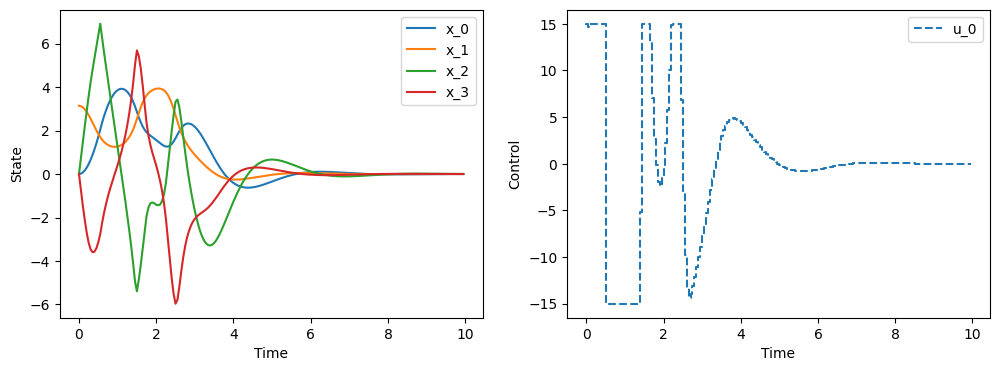

In [8]:
X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("State")

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Control")

plt.savefig("images/chap5_mpc.png")
plt.show()

# アニメーションの作成

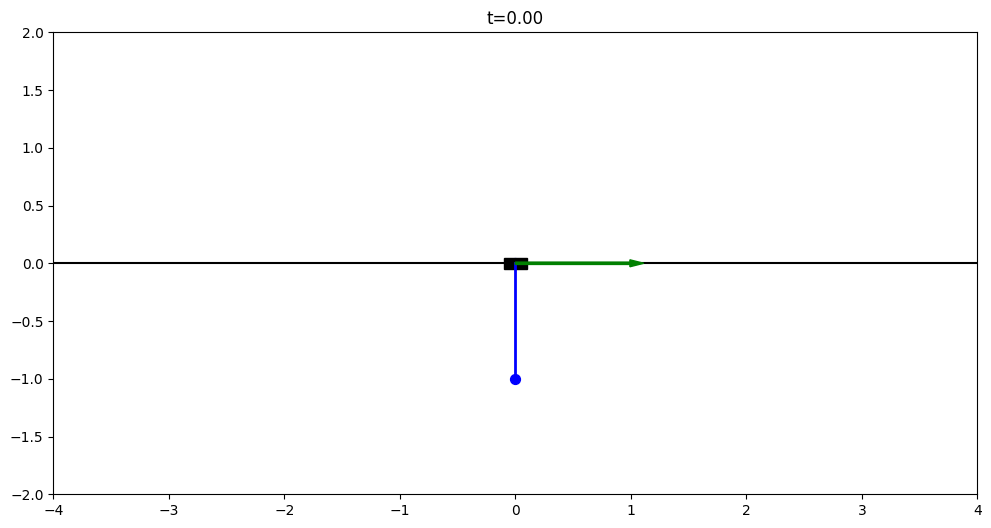

In [9]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
frames = np.arange(0,t_eval.size)
fps = 1 / dt

def update_figure(i):
    x_lim_min = -4
    x_lim_max = 4
    y_lim_min = -2
    y_lim_max = 2
    u_scale = 15

    ax.cla()
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.set_ylim(y_lim_min, y_lim_max)
    ax.set_aspect("equal")
    ax.set_title(f"t={t_eval[i]:0.2f}")

    x,theta,_,_ = X[i]
    u, = U[i]

    points = np.array([
        [x,x-l*np.sin(theta)],
        [0,l*np.cos(theta)]
    ])

    ax.hlines(0,x_lim_min,x_lim_max,colors="black")
    ax.scatter(*points,color="blue", s=50)
    ax.plot(*points, color='blue', lw=2)
    ax.arrow(x,0,u/u_scale,0,width=0.02,head_width=0.06,head_length=0.12,length_includes_head=False,color="green",zorder=3)

    w = 0.2
    h = 0.1
    rect = patches.Rectangle(xy=(x-w/2,-h/2), width=w, height=h,color="black")
    ax.add_patch(rect)

ani = FuncAnimation(fig, update_figure, frames=frames)
ani.save("images/chap5_cart_pole.gif",writer="pillow",fps=fps)

In [10]:
# import os
# import shutil
# import glob
# import natsort
# import cv2
# shutil.rmtree("./tmp",ignore_errors=True)
# os.mkdir("./tmp")
# for i in np.linspace(0,99,12):
#     i = int(i)
#     update_figure(i)
#     fig.savefig(f"./tmp/_frame_{i}.png")
# paths = glob.glob("./tmp/*.png")
# paths = natsort.natsorted(paths)
# paths = [cv2.imread(path) for path in paths]
# paths = np.stack(paths,axis=0)
# paths = paths.reshape((4,3) + paths[0].shape)
# paths = np.concatenate(paths,axis=1)
# paths = np.concatenate(paths,axis=1)
# cv2.imwrite("images/chap5_cart_pole_anim.png",paths)
# shutil.rmtree("./tmp",ignore_errors=True)

In [11]:
# import glob
# import natsort
# import cv2
# for i in np.linspace(0,199,12):
#     i = int(i)
#     update_figure(i)
#     fig.savefig(f"./tmp/_frame_{i}.png")
# paths = glob.glob("./tmp/*.png")
# paths = natsort.natsorted(paths)
# paths = [cv2.imread(path) for path in paths]
# paths = np.stack(paths,axis=0)
# paths = paths.reshape(4,3,600,1200,3)
# paths = np.concatenate(paths,axis=1)
# paths = np.concatenate(paths,axis=1)
# # paths = cv2.resize(paths,dsize=None,fx=1/3,fy=1/3)
# cv2.imwrite("images/chap5_cart_pole_anim.png",paths)